# Purpose

This notebook serves as a documentation of my work through Chapter 10 of [Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291).  This chapter is an introduction to Artificial Neural Networks (ANN) using Keras and Tensorflow.

# Playground

First and foremost, the [Tensorflow Playground](https://playground.tensorflow.org) is a great place to gain some intuition about how ANNs work.  You can change hyperparameters live and see the effect in real time on the output, training, loss, etc.  You can also view each individual weight and output.  

In [1]:
import tensorflow as tf
from tensorflow import keras

print("tf version:", tf.__version__, ", keras version:", keras.__version__)



2023-01-19 11:14:31.902555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.10.0 , keras version: 2.10.0


# Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset will be used throughout these examples.  It is a collection of clothing images that belong to 10 different classes.  It is similar to the more common [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, except it is more complex than hand-written images.  It can be loaded directly from `keras`.

Below, Im loading the dataset, splitting off a validation set, and normalizing the values.  Then, I'm defining the classes and printing out 4 random examples of each class.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print("Train shape: ", X_train.shape, ", data type: ", X_train.dtype)
print("Valid shape: ", X_valid.shape, ", data type: ", X_valid.dtype)
print("Test shape: ", X_test.shape, ", data type: ", X_test.dtype)



Train shape:  (55000, 28, 28) , data type:  float64
Valid shape:  (5000, 28, 28) , data type:  float64
Test shape:  (10000, 28, 28) , data type:  uint8


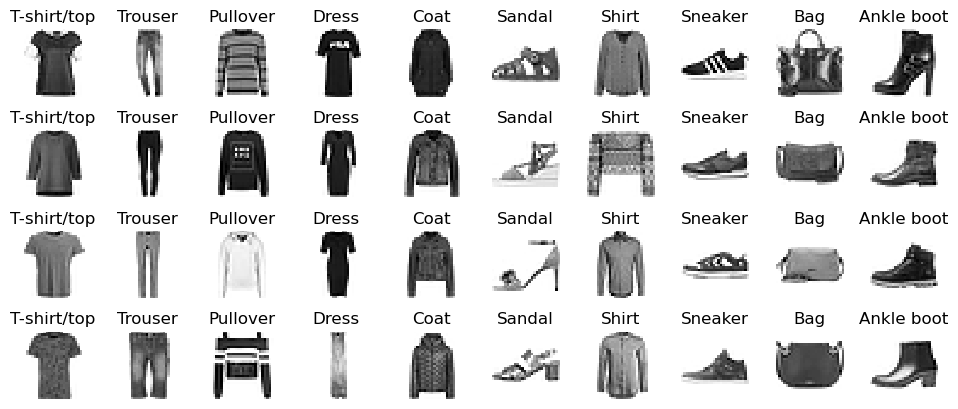

In [3]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

n_rows = 4
n_cols = len(class_names)
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        fig_index = n_cols * row + col + 1
        class_index = col
        X_subset = X_train[y_train == class_index]
        plt.subplot(n_rows, n_cols, fig_index)
        plt.imshow(
            X_subset[np.random.choice(X_subset.shape[0]), :],
            cmap="binary",
            interpolation="nearest",
        )
        plt.axis("off")
        plt.title(class_names[class_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()


# Image Classifier using Sequential API

## Define Layers and Connections

Here we will build a model using the sequential API, which is the simplest method of building an ANN using `keras`.  As it's name suggests, you simply define each layer sequentially to build the network from start to finish, defining the type of layer, number of nodes, and activation function for each.  The model below begins with a `Flatten` layer which simply takes the 28 x 28 images and flatten them down into 1-d.  The next three layers are `Dense` meaning they are fully connected.  The final layer uses a softmax activation because the final classes are exclusive.

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


2023-01-19 11:14:47.592215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notice that the first layer has 235,500 parameters which is (28 * 28) * 300 connection weights plus 300 bias terms.  Dense layers have many parameters because they're fully connected which makes them very flexible but also prone to overfitting.  All layer information is available by accessing the layer directly, as seen below.  Notice the weights are initilized randomly which is necessary to break symmetry.  The initialization method can be changed by setting the `kernal_initializer`.  If the input shape is not specified when building the model above, then the shape of the weight matrix is not known and Keras will not initialize the weights until it knows the input shape. 

In [8]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
print(f'''
layer name: {hidden1.name}
first 20 weights: {weights[0:20,0]}
weights shape: {weights.shape}
first 20 biases: {biases[0:20]}
biases shape: {biases.shape}
''')


layer name: dense
first 20 weights: [ 0.05916254 -0.06415203  0.06863342 -0.02780407  0.04273787  0.01792575
 -0.04729041 -0.07069748  0.01877663  0.04182856 -0.01397761 -0.07201606
 -0.05196963 -0.00393892 -0.07214385  0.01300376  0.0019697   0.02076966
  0.01655266 -0.03836976]
weights shape: (784, 300)
first 20 biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
biases shape: (300,)



## Compile the Model

Now I need to compile the model and specify the loss function, optimizer, and any additional metrics to be evaluated during training.  Note that it's important to tune the learning rate, so usually you'd want to specify it when compiling, e.g. `optimizer=keras.optimizers.SGD(lr=???)` and not simply use the default value of 0.01.

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

## Train and Evaluate the Model

Training the model is as simple as calling the `fit` method along with supplying the training data, validation data, and number of training epochs.

In [12]:
model.fit(X_train, y_train, epochs=30, validation_data=[X_valid, y_valid])

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7190 - accuracy: 0.7647 - val_loss: 0.5209 - val_accuracy: 0.8252
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4881 - accuracy: 0.8298 - val_loss: 0.4486 - val_accuracy: 0.8490
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4393 - accuracy: 0.8461 - val_loss: 0.4399 - val_accuracy: 0.8424
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4133 - accuracy: 0.8551 - val_loss: 0.4020 - val_accuracy: 0.8622
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3934 - accuracy: 0.8619 - val_loss: 0.3923 - val_accuracy: 0.8628
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3770 - accuracy: 0.8677 - val_loss: 0.3737 - val_accuracy: 0.8712
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3633 - accuracy: 0.8716 - val_loss: 0.3744 - val_accuracy: